#### Twitter API

In order to scrape tweets to form our "current" database, we had to connect with the Twitter API by getting access through our Twitter account to scrape. Once we were granted permission to scrape, we connected to the API using the code in the cell directly below. After connecting to the API, we created a csv file using the query "trump" to scrape tweets containing the word or hashtag "trump". The file's columns are as follows: Date, Tweet, Name, Screen Name, Retweets, Favorites.

We attempted to collect tweets over the entire month of August, yet due to Twitter restrictions, we were only able to collect our tweets from the day we ran the scraping. 

We also attempted to create a large database, yet we could only scrape one hundred tweets at a time. To remedy this, we created a loop that created 40 files of tweets and combined them using the UNIX command `cat *.csv > currenttweetdatabase.csv`.

In [4]:
import numpy as np
import pandas
import re

import tweepy
from textblob import TextBlob 

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from statistics import mean, stdev
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

import math

In [ ]:
# authorizes twitter OAuthHandler
def setup():
    consumer_key = "
    consumer_secret = "
    access_token = "
    access_token_secret = "
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    api = tweepy.API(auth, wait_on_rate_limit = True)
    return api

In [ ]:
# creates csv file
def tweets_csv(number, start_date, end_date):
    tweets = setup().search(q = "trump", lang = "en", since = start_date, until = end_date)
    
    data = pandas.DataFrame(data = [tweet.created_at for tweet in tweets], columns = ['Date'])
    data['Tweet'] = np.array([tweet.text for tweet in tweets])
    data['Name'] = np.array([tweet.user.name for tweet in tweets])
    data['Screen Name'] = np.array([tweet.user.screen_name for tweet in tweets])
    data['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])
    data['Favorites'] = np.array([tweet.favorite_count for tweet in tweets])

    data.to_csv("tweetdatabase{}.csv".format(number), sep = '\t', encoding = 'utf-8')

#for i in range(40):
    #tweets_csv(i, "2018-09-29", "2018-09-30")
    
#tweets_csv(i, "2018-09-29", "2018-09-30")

#### Data Preprocessing

In order to gain a more accurate reading from our sentiment analysis, we ran some preprocessing on our datasets. We removed the stop words from the tweets using the stop words provided from the NLTK library. Then we made all words lower cased. Finally, we removed all web links, at symbols, hashtags, and traces of the word "RT" (retweet).

In [21]:
# sets stop words from NLTK
stop_words = set(stopwords.words('english'))

# preprocesses data as whole
def clean(filename, column):
    df = pandas.read_csv(filename)
    df = df[column]
    
    # all words to lower case
    df = df.apply(lambda x: ' '.join([word.lower() for word in x.split()]))
    
    # removes stop words
    df = df.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    # removes http, @, #, and rt
    df = df.apply(lambda x: ' '.join([word for word in x.split()
                                     if 'http' not in word
                                     and not word.startswith('@')
                                     and not word.startswith('#')
                                     and word != 'rt']))
    
    return df

#current_data = clean('tweets/currenttweetdatabase.csv', 'Tweet')
#election_day_data = clean('tweets/election_day_tweets.csv', 'text')

# preprocesses invidual tweet
def clean_tweet(tweet):
    # all words to lower case
    tweet = tweet.lower()
    
    # removes stop words
    tweet = ' '.join([word for word in tweet.split() if not word in stop_words])
    
    # removes http, @, #, and rt
    tweet = ' '.join([word for word in tweet.split()
                              if 'http' not in word
                              and not word.startswith('@')
                              and not word.startswith('#')
                              and word != 'rt'])
    
    return tweet

#### Extracting Feature Vectors

The following code extracts the counts for each, individual word and places it in an array. To see the counts for each word, uncomment the for loop within the `vectorize` function.

In [3]:
# extracts features vectors
def vectorize(data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data)
    #for word in sorted(vectorizer.vocabulary_):
        #print("{}: {}".format(word, vectorizer.vocabulary_.get(word)))

    return vectorizer.fit_transform(data)

X_train_counts_current = vectorize(current_data)
X_train_counts_election_day = vectorize(election_day_data)

#### Sentiment Analysis [TextBlob]

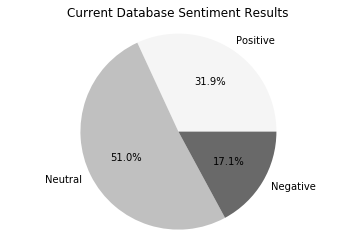

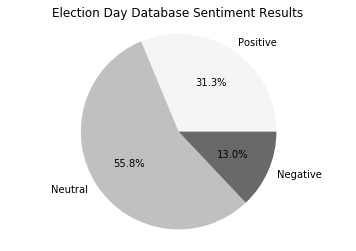

In [24]:
# sentiment analysis using TextBlob

def analize_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else: return -1
    
def sentiment_analysis_textblob(filename, column, title):
    df = pandas.read_csv(filename)

    df['SA'] = np.array([analize_sentiment(tweet) for tweet in df[column]])

    pos_tweets = [tweet for index, tweet in enumerate(df[column]) if df['SA'][index] > 0]
    neu_tweets = [tweet for index, tweet in enumerate(df[column]) if df['SA'][index] == 0]
    neg_tweets = [tweet for index, tweet in enumerate(df[column]) if df['SA'][index] < 0]
    
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [len(pos_tweets) * 100 / len(df[column]),
             len(neu_tweets) * 100 / len(df[column]),
             len(neg_tweets) * 100 / len(df[column])]
    color = ['whitesmoke', 'silver' , 'dimgray']
    
    plt.pie(sizes, labels=labels, colors=color, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(title)
    plt.show()
    
    #print("Percentage of positive tweets: {}%".format(len(pos_tweets) * 100 / len(df[column])))
    #print("Percentage of neutral tweets: {}%".format(len(neu_tweets) * 100 / len(df[column])))
    #print("Percentage of negative tweets: {}%\n".format(len(neg_tweets) * 100 / len(df[column])))

    dict = {"pos": len(pos_tweets)/len(df[column]), 
            "neu": len(neu_tweets)/len(df[column]), 
            "neg": len(neg_tweets)/len(df[column]),
            "mean": mean([len(pos_tweets)/len(df[column]), len(neu_tweets)/len(df[column]), len(neg_tweets)/len(df[column])]),
            "standard deviation": stdev([len(pos_tweets)/len(df[column]), len(neu_tweets)/len(df[column]), len(neg_tweets)/len(df[column])]),
            "size": len(df)}
    
    return dict

current = sentiment_analysis_textblob('tweets/currenttweetdatabase.csv', 'Tweet', 'Current Database Sentiment Results')
election_day = sentiment_analysis_textblob('tweets/election_day_tweets.csv', 'text', 'Election Day Database Sentiment Results')

#### Statistics

Below shows the mean, standard deviation, and t-test statistics for both sentiment analysis runs.

In terms of the t-test, since their t statistic is zero and the sig level is below 0.05, there was not much of a significant difference in sentiment between the two analysis runs.

In [23]:
# prints out statistics
print('Current')
for word in sorted(current):
    print("\t{}: {}".format(word, current.get(word)))
    
print('Election Day')
for word in sorted(election_day):
    print("\t{}: {}".format(word, election_day.get(word)))

Current
	mean: 0.3333333333333333
	neg: 0.17109634551495018
	neu: 0.5099667774086378
	pos: 0.31893687707641194
	size: 6020
	standard deviation: 0.16989330730644361
Election Day
	mean: 0.33333333333333337
	neg: 0.12962334236184986
	neu: 0.5577208905789065
	pos: 0.3126557670592437
	size: 397629
	standard deviation: 0.21479652931932655


In [5]:
# calculates t-test
difference = 0.33333333333333337 - 0.3333333333333333
sqrt_devs = math.sqrt(((0.21479652931932655 ** 2)/397629) + ((0.16989330730644361 ** 2)/6020))
t_stat = difference/sqrt_devs

print("{}: {}".format("T-test Statistics for Overall Mean", t_stat))

T-test Statistics for Overall Mean: 2.5050117281212668e-14


#### Streaming

As an aside, we created a Twitter Stream which pulls Tweets in real time using the query "trump".

In [ ]:
# twitter stream
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        display(status.text)
        
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = setup().auth, listener = MyStreamListener())
myStream.filter(track=['trump'])

#### Sources

[Mining Twitter Data with Python (Part 6 – Sentiment Analysis Basics)](https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/)<br>
[Sentiment Analysis with Python (Part 1)](https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184)<br>
[Sentiment analysis on Trump's tweets using Python 🐍](https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-)<br>
[T-Test in Python](https://plot.ly/python/t-test/)<br>
[Python NLTK sentiment analysis](https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis/notebook)<br>
[Basic Data Cleaning/Engineering Session | Twitter Sentiment Data](https://medium.com/@SeoJaeDuk/basic-data-cleaning-engineering-session-twitter-sentiment-data-b9376a91109b)

##### Data Sets
[Election Day Tweets](https://www.kaggle.com/kinguistics/election-day-tweets)<br>
[September 2018 Donald Trump-Related Tweets](https://www.kaggle.com/thomascedge/september-2018-trump-tweets)